# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">Jan Aguiló Plana</font>

E-mail: <font color="blue">jan.aguilo01@estudiant.upf.edu</font>

Date: <font color="blue">30/10/2024</font>

In [33]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [34]:
# Leave this code as-is

FILENAME_MOVIES = "data/movielens-25M-filtered/movies-2000s.csv"
FILENAME_RATINGS = "data/movielens-25M-filtered/ratings-2000s.csv"
FILENAME_TAGS = "data/movielens-25M-filtered/tags-2000s.csv"

In [35]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

In [36]:
def yearof(film_name):
    year = []
    # The idea is go through every character of the name, save the ones that are numbers and print the last 4, 
    # corresponding to the year of the movie
    for char in film_name:
        if char.isdigit():
            year.append(char)
    return int(''.join(year[-4:]))

movies['year'] = movies.apply(lambda x: yearof(x['title']), axis=1) 
movies.head()

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and movies.</font>

We will join them on the field they both have in common, the movie_id. In this way we can relate the ratings with the name movies, year, etc.

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, title, genders, year</font>

In [37]:
ratings = pd.merge(ratings_raw, movies, how='inner', on='movie_id')
ratings.head()

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,4,3751,3.5,Chicken Run (2000),Animation|Children|Comedy,2000
2,4,3793,1.5,X-Men (2000),Action|Adventure|Sci-Fi,2000
3,4,3827,3.0,Space Cowboys (2000),Action|Adventure|Comedy|Sci-Fi,2000
4,4,4308,3.5,Moulin Rouge (2001),Drama|Musical|Romance,2001


<font size="+1" color="red">Replace this cell with your code for find _movies</font>

In [38]:
def find_movies(keyword, movies):
    # We go through each of the movies and if the keyoword is in its title then we print it in the specified format
    for i in range(len(movies)):
        if keyword in movies['title'][i]:
            print(f"movie_id: {movies['movie_id'][i]}, title: {movies['title'][i]}")
            
find_movies("Barcelona", movies)            

movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [39]:
# LEAVE AS-IS

ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

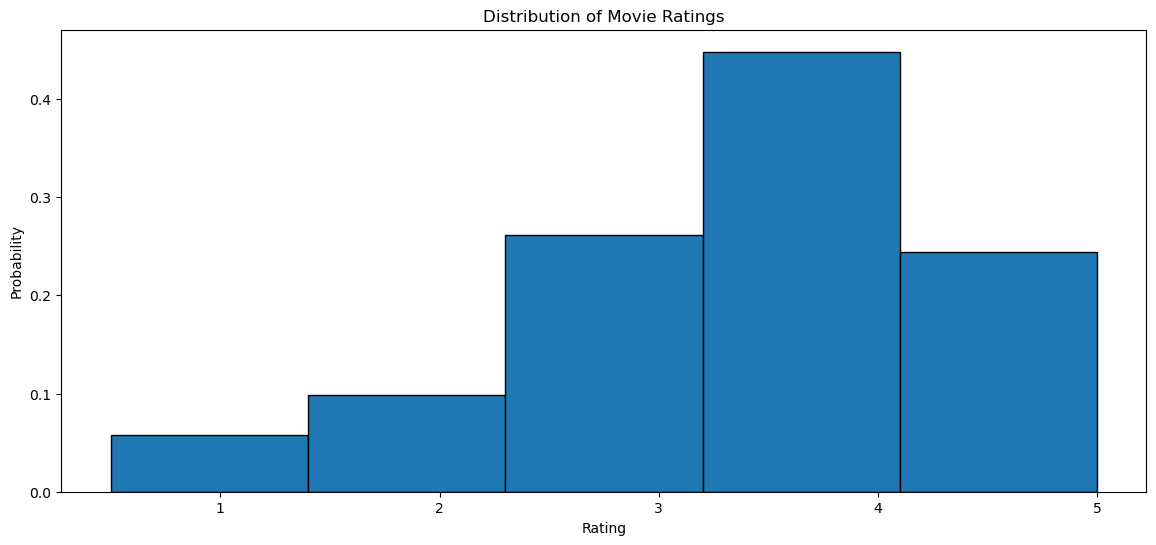

In [40]:
plt.figure(figsize=(14, 6)) 
plt.hist(ratings['rating'], bins=5, density=True, edgecolor='black')

plt.xlabel("Rating")
plt.ylabel("Probability")
plt.title("Distribution of Movie Ratings")

plt.show()

<font size="+1" color="red">Replace this cell with your code to plot a boxplot of ratings. Look for outlier values. </font>

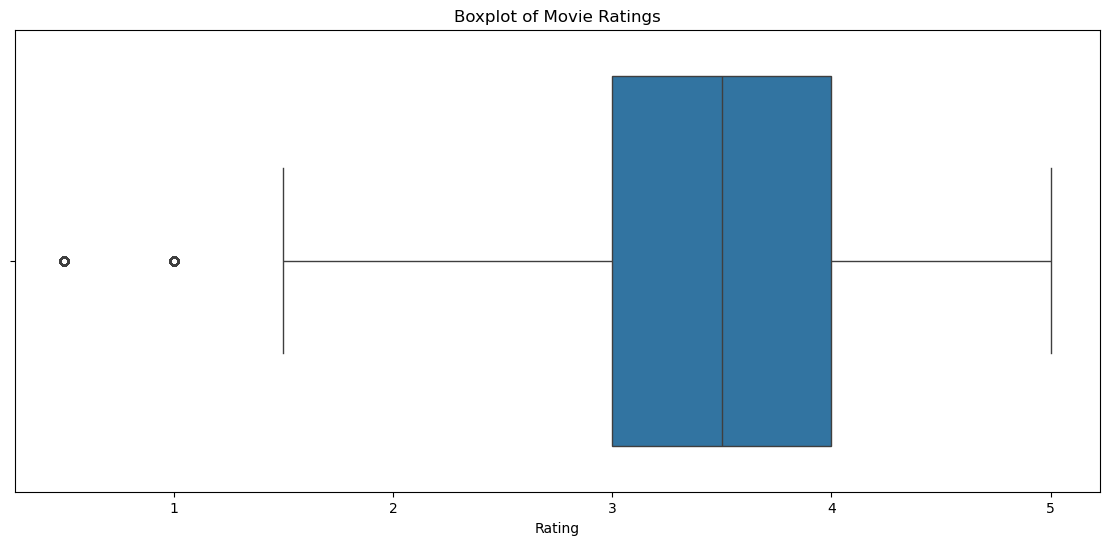

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

sns.boxplot(x=ratings['rating'])

plt.xlabel("Rating")
plt.title("Boxplot of Movie Ratings")

plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

The boxplot reveals that ratings are mostly concentrated between 3 and 4, with a median around 3.5, suggesting that users tend to give moderately high ratings. The distribution is slightly right-skewed, as seen from the longer upper whisker, indicating a tendency toward higher scores. 

There are a few low outliers near 1, which may represent a small number of particularly low ratings. Overall, the pattern suggests positive user feedback, with most ratings falling in the mid-to-high range.

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are larger than 4.5), and the 10 movies with the most "bad" ratings (i.e., ratings than are smaller than 1.5)</font>

In [42]:
# Good_ratings
good_ratings = ratings[ratings['rating'] > 4.5]

# Count the occurrences of each movie_id in good_ratings and get the top 10
top_good_movies = good_ratings['title'].value_counts().nlargest(10)
print("Top 10 movies with the most 'good' ratings:")
print(top_good_movies)


# Bad_ratings
bad_ratings = ratings[ratings['rating'] < 1.0]

# Count the occurrences of each movie_id in bad_ratings and get the top 10
top_bad_movies = bad_ratings['title'].value_counts().nlargest(10)

print("\nTop 10 movies with the most 'bad' ratings:")
print(top_bad_movies)

Top 10 movies with the most 'good' ratings:
title
Lord of the Rings: The Fellowship of the Ring, The (2001)    1973
Lord of the Rings: The Return of the King, The (2003)        1806
Lord of the Rings: The Two Towers, The (2002)                1693
Memento (2000)                                               1255
Gladiator (2000)                                             1156
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1116
Eternal Sunshine of the Spotless Mind (2004)                  959
Spirited Away (Sen to Chihiro no kamikakushi) (2001)          862
Shrek (2001)                                                  734
Kill Bill: Vol. 1 (2003)                                      718
Name: count, dtype: int64

Top 10 movies with the most 'bad' ratings:
title
Battlefield Earth (2000)                                     103
Scary Movie (2000)                                            93
Charlie's Angels (2000)                                       85
Star Wars: Episode 

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

The top 10 movies with the most "good" ratings show that films like Lord of the Rings and Gladiator have lots of fans. These movies are clearly loved by a lot of people and often seen as classics. Other films like Memento and Amelie also appear, indicating that they have a strong positive impact on viewers.

When it comes to "bad" ratings, movies like Battlefield Earth and Scary Movie are at the bottom, which isn’t surprising given their reputation for being poorly received. It’s interesting that Lord of the Rings: The Fellowship of the Ring and Kill Bill: Vol. 1 show up here too, suggesting that even popular movies can have a section of fans who just didn’t connect with them. It’s a reminder that not every movie is for everyone.

## 2.2. Genres distribution

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 20 genres with an assert, as follows:
    assert(n == 20).</font>

In [43]:
# Separate by | , stack, and use unique function in order to find all the different genres 
movie_genres = movies['genres'].str.split('|', expand=True).stack()
movie_genres_unique = movie_genres.unique()
# Create the table as a dataframe
genre_table = pd.DataFrame(movie_genres_unique, columns = ['Genre'])

# Display the genre table
print(genre_table)
assert(len(genre_table)==20)

                 Genre
0                Crime
1                Drama
2               Comedy
3            Adventure
4               Sci-Fi
5             Thriller
6              Romance
7               Horror
8              Mystery
9               Action
10           Animation
11            Children
12         Documentary
13                 War
14             Musical
15             Western
16             Fantasy
17                IMAX
18           Film-Noir
19  (no genres listed)


<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre in the dataset, check that it returns the same result as above. Create a function that receives all relevant arguments and returns the dataframe (feel free to use auxiliary functions). Do not use global variables.</font>

In [44]:
def genre_count_display(movies):

    # Extract the genres from a dataset
    movie_genres = movies['genres'].str.split('|', expand=True).stack()

    # Count occurrences of each genre
    genre_count = movie_genres.value_counts()

    # Create the specified DataFrame
    genre_count = pd.DataFrame({'genre': genre_count.index, 'count': genre_count.values})
    

    return genre_count

genre_count = genre_count_display(movies)
display(genre_count)

,genre,count
0,Drama,13666
1,Comedy,8898
2,Thriller,5437
3,Documentary,4473
4,Action,3901
5,Romance,3846
6,Horror,3431
7,Crime,2425
8,(no genres listed),2200
9,Sci-Fi,1907


<font size="+1" color="red">Replace this cell with code to produce two bar plots: one for movies filmed on 2005 or before, and another for movies filmed on 2016 or later.</font>

[Text(0.5, 1.0, 'Genre Distribution for Movies Filmed in 2005 or before'),
 Text(0.5, 0, 'Number of Movies'),
 Text(0, 0.5, 'Genre')]

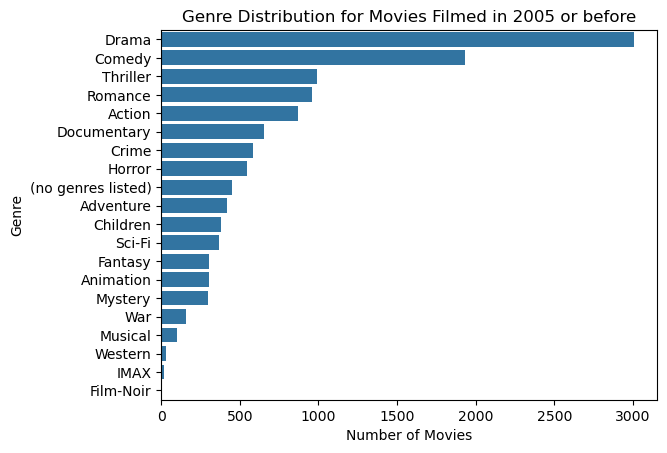

In [45]:
films_2005 = movies[movies['year']<=2005]
genre_count_2005 = genre_count_display(films_2005)
bar_plot_2005 = sns.barplot(x=genre_count_2005['count'], y=genre_count_2005['genre'], orient='h')
bar_plot_2005.set(title='Genre Distribution for Movies Filmed in 2005 or before', xlabel='Number of Movies', ylabel='Genre')

[Text(0.5, 1.0, 'Genre Distribution for Movies Filmed in 2016 or after'),
 Text(0.5, 0, 'Number of Movies'),
 Text(0, 0.5, 'Genre')]

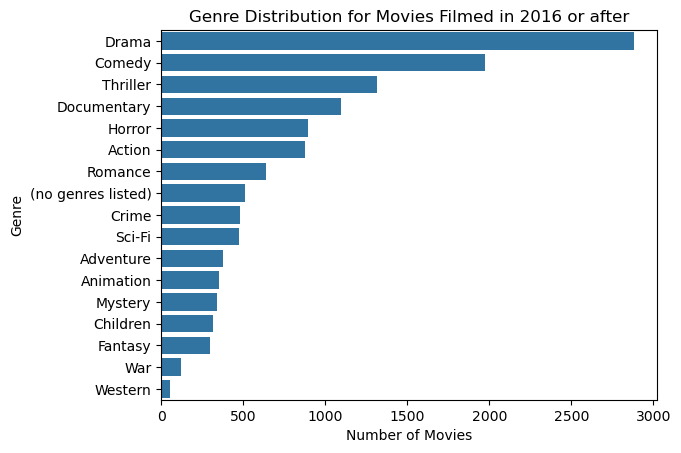

In [46]:
films_2016 = movies[movies['year']>=2016]
genre_count_2016 = genre_count_display(films_2016)
bar_plot_2016 = sns.barplot(x=genre_count_2016['count'], y=genre_count_2016['genre'], orient='h')
bar_plot_2016.set(title='Genre Distribution for Movies Filmed in 2016 or after', xlabel='Number of Movies', ylabel='Genre')

<font size="+1" color="red">Replace this cell with a brief commentary comparing both distributions, including which genres changed popularity.</font>

The genre distribution for movies filmed in 2005 or before and those filmed in 2016 or after shows some shifts in popularity. Drama remains the most dominant genre across both timeframes, reflecting its enduring appeal. Comedy and thriller also maintain strong positions in both periods, though their relative proportions seem slightly reduced in the later period.

Horror and documentary genres show a notable rise in prominence in movies filmed in 2016 or later, suggesting growing interest in these categories. Meanwhile, genres like westerns and musicals remain less popular in both periods but have further diminished in the more recent films. These changes highlight evolving audience preferences, with newer genres gaining traction over time.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

In [47]:
movies['genres_arr'] = movies['genres'].str.split('|')
movies['genres_arr'].fillna('').astype('str')
print(movies['genres_arr'])

0                       [Crime, Drama]
1                             [Comedy]
2        [Adventure, Sci-Fi, Thriller]
3                    [Comedy, Romance]
4                             [Comedy]
                     ...              
33163        [Action, Comedy, Romance]
33164                          [Drama]
33165                    [Documentary]
33166                  [Comedy, Drama]
33167             [(no genres listed)]
Name: genres_arr, Length: 33168, dtype: object


In [48]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [49]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year >= 2016]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,[(no genres listed)]
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"[Action, Adventure, Fantasy]"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,[(no genres listed)]
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"[Action, Adventure, Sci-Fi]"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"[Action, Adventure, Comedy, Sci-Fi]"


<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

In [50]:
# Stop_words english removes common stop words to focus on more meaningful genres
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies_filtered['genres'])

print(tfidf_matrix.shape)

(7890, 128)


## 3.2. Calculate most similar movies

The next code, which you should leave as-is, uses sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function, which is a fast way of computing these similarities on a matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [51]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [52]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

0.133 188575 Zombies (2018)
0.000 188581 Las furias (2016)
0.000 188583 The Strange Name Movie (2017)
0.178 188585 Enissa Amani: Ehrenwort (2018)
0.000 188597 Embrace (2016)
0.000 188603 Breath (2018)
0.000 188605 The Sower (2017)
0.000 188607 The Green Fog (2017)
0.000 188609 The Snatch Thief (2018)
0.000 188613 Lost in Vagueness (2018)
0.000 188619 Denmark (2017)
0.000 188623 Burning (2018)
0.000 188625 Evil Genius: The True Story of America's Most Diabolical Bank Heist (2018)
0.403 188641 Pilgrimage (2017)
0.000 188643 The Battle Of Chosin (2016)
0.000 188645 Exorcism (2017)
0.000 188659 Little Woods (2018)
0.000 188663 Itzhak (2017)
0.000 188665 Last Days in Havana (2016)
0.039 188671 Glossary of Broken Dreams (2018)
0.000 188675 Dogman (2018)
0.363 188679 Fahrenheit 451 (2018)
0.178 188693 Once Upon a Time (2018)
0.000 188695 The Cleaners (2018)
0.000 188697 Happy as Lazzaro (2018)
0.000 188705 Girl in the Bunker (2018)
0.087 188709 Detours (2016)
0.179 188731 Taxi 5 (2018)
0.000 

0.000 194598 Man in the Well (2016)
0.087 194602 Dying to Survive (2018)
0.000 194606 Forever Young (2018)
0.000 194608 The Black Book (2018)
0.052 194610 Dead Pigs (2018)
0.000 194612 Dreaming Murakami (2018)
0.000 194616 The Quest of Alain Ducasse (2017)
0.000 194618 Gosnell: The Trial of America's Biggest Serial Killer (2018)
0.000 194620 X&Y (2018)
0.000 194628 Der Junge muss an die frische Luft (2018)
0.178 194632 25 km/h (2018)
0.000 194634 The Amityville Murders (2018)
0.000 194636 I Still See You (2018)
0.000 194638 The Kindergarten Teacher (2018)
0.000 194642 The Last Ones (2018)
0.248 194644 The Nanny (2018)
0.087 194646 Tyrel (2018)
0.000 194648 Tilt (2017)
0.000 194656 Night Comes On (2018)
0.000 194662 Jailhouse Socrates (2017)
0.000 194664 They Shall Not Grow Old (2018)
0.000 194666 Roads in February (2018)
0.000 194678 Taste of Cement (2017)
0.359 194680 Twisted Pair (2018)
0.000 194682 Uma Vida Sublime (2018)
0.000 194686 Black Tide (2018)
0.000 194692 Boar (2018)
0.000

0.119 197045 Dealer/Healer (2017)
0.327 197047 F.R.E.D.I. (2018)
0.000 197049 After the Screaming Stops (2018)
0.305 197067 At First Light (2018)
0.178 197071 Bad Seeds (2018)
0.037 197073 Bees Make Honey (2018)
0.095 197075 Kadaikutty Singam (2018)
0.000 197077 One Week Friends (2017)
0.119 197079 Killing (2018)
0.000 197085 Ladies First (2017)
0.000 197087 Daughter of Mine (2018)
0.178 197091 How to Be Really Bad (2018)
0.000 197093 Ragged Life of Juice Leskinen (2018)
0.000 197101 B.C. Butcher (2016)
0.000 197103 Be with You (2018)
0.000 197111 Psychonautics: A Comic's Exploration of Psychedelics (2018)
0.000 197117 The Bill Murray Stories: Life Lessons Learned from a Mythical Man (2018)
0.000 197119 Jinn (2018)
0.178 197121 Igelak (Frogs) (2016)
0.000 197123 Taylor Swift: Reputation Stadium Tour (2018)
0.089 197127 Nota (2018)
0.119 197129 Kaala (2018)
0.000 197131 Humidity (2016)
0.000 197133 Hospitality (2018)
0.000 197141 The Standoff at Sparrow Creek (2019)
0.000 197143 Donnybr

0.000 203026 Mollywood (2019)
0.000 203028 Red Room (2017)
0.000 203030 Love for Sale (2018)
0.000 203032 Death Zone: Cleaning Mount Everest (2018)
0.000 203034 The River and the Wall (2019)
0.056 203036 Twenty One Points (2018)
0.363 203038 The Final Land (2019)
0.094 203040 Pachamama (2018)
0.000 203048 Diego Maradona (2019)
0.000 203060 Worlds of Ursula K. Le Guin (2018)
0.000 203066 Light from Light (2019)
0.178 203068 Get Big (2017)
0.000 203072 I Am Evidence (2017)
0.000 203076 Deja Vu (2018)
0.000 203078 Door Lock (2018)
0.106 203080 Hit-and-Run Squad (2019)
0.000 203086 Truth and Justice (2019)
0.000 203090 The Announcement (2018)
0.000 203110 Head Count (2018)
0.000 203112 Walk. Ride. Rodeo. (2019)
0.000 203128 I Was a Winner (2016)
0.000 203130 Cutterhead (2018)
0.000 203132 The Tomorrow Man (2019)
0.000 203134 Curiosa (2019)
0.000 203136 The Heart of Nuba (2016)
0.000 203144 The Cleaning Lady (2018)
0.000 203146 The Last Whistle (2018)
0.178 203148 Old Boys (2018)
0.108 2031

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

In [53]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    sim_scores = similarities[index_source]
    
    enumerated = list(enumerate(sim_scores))
    sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = sorted_similarities[0:num_movies]

    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        movie_id = movies_filtered.iloc[index_target].movie_id
        title = movies_filtered.iloc[index_target].title
        genres = movies_filtered.iloc[index_target].genres
        
        
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

<font size="+1" color="red">Replace this cell with code to print the top 10 recommendations for movie "Pirates of the Caribbean" (movie_id=122896) and "Midsommer" (movie_id=201646).</font>

In [54]:
genre_content_based_recommendations(122896, movies, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,122888,Ben-hur (2016),(no genres listed)
1,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
2,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
3,1.0,138212,Spectral (2016),(no genres listed)
4,1.0,141131,Guardians (2016),(no genres listed)
5,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
6,1.0,150724,Army Dog (2016),(no genres listed)
7,1.0,151461,Fitoor (2016),(no genres listed)
8,1.0,151593,Martyrs (2016),(no genres listed)
9,1.0,152037,Grease Live (2016),(no genres listed)


In [55]:
genre_content_based_recommendations(201646, movies, cosine_sim, num_movies=10)

,similarity,movie_id,title,genres
0,1.0,155064,The Neon Demon (2016),Drama|Horror|Mystery
1,1.0,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
2,1.0,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
3,1.0,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
4,1.0,184067,Without Name (2017),Drama|Horror|Mystery
5,1.0,190755,The Little Stranger (2018),Drama|Horror|Mystery
6,1.0,192291,Rift (2017),Drama|Horror|Mystery
7,1.0,201646,Midsommar (2019),Drama|Horror|Mystery
8,1.0,201739,Wounds (2019),Drama|Horror|Mystery
9,1.0,202225,Something (2018),Drama|Horror|Mystery


<font size="+1" color="red">Replace this cell with code to get the list of recommendation for three movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

In [56]:
batman_vs_superman = genre_content_based_recommendations(136864, movies, cosine_sim, num_movies=10)
avengers = genre_content_based_recommendations(122912, movies, cosine_sim, num_movies=10)
star_wars = genre_content_based_recommendations(179819, movies, cosine_sim, num_movies=10)
display(batman_vs_superman)
display(avengers)
display(star_wars)

,similarity,movie_id,title,genres
0,1.000000,122924,X-Men: Apocalypse (2016),Action|Adventure|Fantasy|Sci-Fi
1,1.000000,136864,Batman v Superman: Dawn of Justice (2016),Action|Adventure|Fantasy|Sci-Fi
2,1.000000,143345,Shazam! (2019),Action|Adventure|Fantasy|Sci-Fi
3,1.000000,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
4,1.000000,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi
5,1.000000,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi
6,0.907280,173325,The Northlander (2016),Adventure|Fantasy|Sci-Fi
7,0.907280,200282,The Dark Kingdom (2018),Adventure|Fantasy|Sci-Fi
8,0.750015,122890,Warcraft (2016),Action|Adventure|Fantasy
9,0.750015,122926,Untitled Spider-Man Reboot (2017),Action|Adventure|Fantasy


,similarity,movie_id,title,genres
0,1.0,122898,Justice League (2017),Action|Adventure|Sci-Fi
1,1.0,122906,Black Panther (2017),Action|Adventure|Sci-Fi
2,1.0,122908,Inhumans (2018),Action|Adventure|Sci-Fi
3,1.0,122910,Captain Marvel (2018),Action|Adventure|Sci-Fi
4,1.0,122912,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi
5,1.0,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi
6,1.0,122916,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi
7,1.0,122918,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi
8,1.0,122922,Doctor Strange (2016),Action|Adventure|Sci-Fi
9,1.0,135567,Independence Day: Resurgence (2016),Action|Adventure|Sci-Fi


,similarity,movie_id,title,genres
0,1.000000,122924,X-Men: Apocalypse (2016),Action|Adventure|Fantasy|Sci-Fi
1,1.000000,136864,Batman v Superman: Dawn of Justice (2016),Action|Adventure|Fantasy|Sci-Fi
2,1.000000,143345,Shazam! (2019),Action|Adventure|Fantasy|Sci-Fi
3,1.000000,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
4,1.000000,166528,Rogue One: A Star Wars Story (2016),Action|Adventure|Fantasy|Sci-Fi
5,1.000000,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi
6,0.907280,173325,The Northlander (2016),Adventure|Fantasy|Sci-Fi
7,0.907280,200282,The Dark Kingdom (2018),Adventure|Fantasy|Sci-Fi
8,0.750015,122890,Warcraft (2016),Action|Adventure|Fantasy
9,0.750015,122926,Untitled Spider-Man Reboot (2017),Action|Adventure|Fantasy


In [57]:
# I will mark as relevant the ones that have a 1 and irrelevant the ones that have a 0
relevant_batman = [1,1,0,1,1,1,0,0,0,0]
relevant_avengers = [1,1,1,1,1,1,1,0,0,0]
relevant_starwars = [0,1,0,1,1,1,0,1,0,0]

# Function to calculate the precision for each movie
def calculate_precision(relevant_list):
    relevant_count = sum(relevant_list)
    total_count = len(relevant_list)
    precision = (relevant_count / total_count) * 100
    return precision

# Calculate precision for the three lists
precision_batman = calculate_precision(relevant_batman)
precision_avengers = calculate_precision(relevant_avengers)
precision_starwars = calculate_precision(relevant_starwars)

print("Precision for Recommendations:")
print(f"Batman vs. Superman: {precision_batman:.2f}%")
print(f"Avengers: {precision_avengers:.2f}%")
print(f"Star Wars: {precision_starwars:.2f}%")

average_precision3 = (precision_batman + precision_avengers + precision_starwars)/3
print("Average precision for the three lists:", round(average_precision3,2),"%")

Precision for Recommendations:
Batman vs. Superman: 50.00%
Avengers: 70.00%
Star Wars: 50.00%
Average precision for the three lists: 56.67 %


<font size="+1" color="red">Replace this cell with ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations.</font>

To improve content-based recommendations, incorporating user preferences and ensuring diversity in recommendations are key. Personalization can be enhanced by explicitly considering users' favorite genres, directors, or actors, which can be weighted more heavily in the recommendation algorithm. At the same time, introducing diversity ensures that recommendations include a broader range of content, avoiding redundancy and providing users with varied options. This can be achieved by adding a diversification algorithm that reduces overlap in similar recommendations. Together, these strategies create a more tailored and engaging experience for users while maintaining novelty and exploration.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>